# Seq2Seq Models and Attention


In this tutorial, we will be exploring sequence to sequence(Seq2Seq) models. Then we will improve our network with an attention model. Lastly, we will check the PyTorch implementation of different attention mechanisms.  For this purpose, we will create a simple machine translation that will convert English to French. 
While creating this tutorial following resources are used:


* [NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION]( https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html?highlight=nlp) by Sean Robertson

* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding)

Let's start with going over Seq2Seq models and attention first. As you already know the sequence to sequence models contain 2 different blocks which are Encoder and Decoder. Firstly encoder block gets the input data, in our case a text/sentence, then it collects data from it and puts this information to a hidden state. The decoder block then creates output data using the hidden state created by the encoder function.  These Encoder and Decoder blocks generally contain RNN architectures to capture different sized input/output pairs. 

![seq2seq[1].png](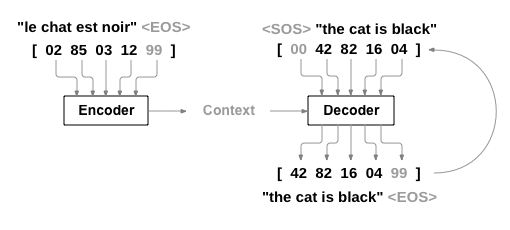)


In NLP this model is generally used for machine translation tasks.  Encoder RNN structure is given a text block to encode LSTM and create and hidden layer. Then Using this hidden layer, we will generate text using output LSTM 

#####**Attention**

The next topic we are going to discuss is attention models. Seq2Seq models have two problems. The first one is the Seq2Seq model tries to contain whole text meaning in a single hidden state. Although this is not a big problem for smaller input-output pairs, when the size gets bigger this creates a problem for the network. This problem is similar to memorizing all of the text to translate it afterward. The second problem comes from relations between the words. Some words meaning change according to their content. While translating the words network doesn't count these relations. 

One of the most used attention functions is dot-product attention. The Dot product attention model works with 3 inputs Q, K, V which represents queries, key, and the value matrices. Firstly We calculate the dot product of the quarry with all keys. Then using softmax we obtain the weights of the values. Then we calculate the dot product of these weights and the values.  

![the-annotated-transformer_33_0[1].png](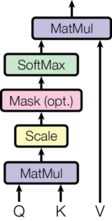)

In this tutorial, We will use global attention model

![attention-decoder-network[1].png](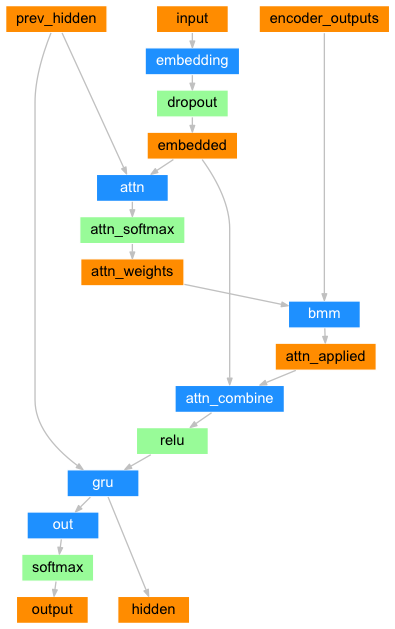)

Image is taken from [pytorch tutorials](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html?highlight=nlp)

##Network

In this part of the tutorial, I will be following the PyTorch tutorial by Sean Robertson.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Colab\ Notebooks/attention

/content/gdrive/MyDrive/Colab Notebooks/attention


In [4]:
%matplotlib inline

###Loading data

I will not be going into the details of data loading and processing in this tutorial but if you are interested you can check the first resource I mentioned at the beginning of this notebook.

In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['il est poissonnier .', 'he is a fishmonger .']


###Seq2Seq Model

####Encoder

Encoder RNN is a simple GRU model that takes input and returns hidden and output layers.

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

####Decoder

Decoder RNN is similar to the encoder with the only difference being it contains a linear layer on top of the GRU to obtain output text. The decoder takes the hidden of the previous state and the output of the previous state. Only in the first iteration Decoder layer takes < SOS > token and hidden state of the encoder

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

####Attention Decoder

The attention Decoder module is an improvement upon the Decoder model with including attention mechanism. We discussed its architecture in the previous part.  The only thing to consider is because we will be doing a dot product we need to set maximum  sentence length.

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

###Training

####Preparing Data

While creating our data we will append < EOS > token in both input and output tensors.

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

####Training the model

Training is straightforward. Firstly we will call our encoder and obtain hidden and output data. Then using the outputs of the Encoder we will train the network using the teacher forcing method. 

The author of the PyTorch tutorial says that ` Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.` For this purpose, it creates `teacher_forcing_ratio`. This ratio helps us select whether to use teacher forcing or not with a simple if statement.

In [14]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [17]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

####Evaluate

Evaluation is similar to the train loop, the difference is there are no target words.

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

###Training and Evaulation

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 8s (- 16m 0s) (5000 6%) 2.8753
2m 16s (- 14m 44s) (10000 13%) 2.2995
3m 22s (- 13m 31s) (15000 20%) 1.9687
4m 30s (- 12m 22s) (20000 26%) 1.7280
5m 36s (- 11m 13s) (25000 33%) 1.5428
6m 43s (- 10m 5s) (30000 40%) 1.3657
7m 50s (- 8m 57s) (35000 46%) 1.2285
8m 56s (- 7m 49s) (40000 53%) 1.0966
10m 3s (- 6m 42s) (45000 60%) 0.9790
11m 10s (- 5m 35s) (50000 66%) 0.9031
12m 18s (- 4m 28s) (55000 73%) 0.8236
13m 25s (- 3m 21s) (60000 80%) 0.7316
14m 31s (- 2m 14s) (65000 86%) 0.6713
15m 39s (- 1m 7s) (70000 93%) 0.6035
16m 46s (- 0m 0s) (75000 100%) 0.5813


In [21]:
evaluateRandomly(encoder1, attn_decoder1)

> maintenant il court .
= he is running now .
< he is running in the <EOS>

> je ne suis pas encore mort .
= i m not dead yet .
< i m not dead yet . <EOS>

> vous etes fort ingenieuse .
= you re very clever .
< you re very clever . <EOS>

> c est un bel homme .
= he is a handsome man .
< he is a man man . <EOS>

> il est membre du conseil paroissial .
= he is a member of the parish committee .
< he is a member of the committee committee . <EOS>

> je ne te le dis pas .
= i m not telling you .
< i m not telling you . <EOS>

> c est toi l enseignante .
= you re the teacher .
< you re the teacher . <EOS>

> je ne suis simplement pas tres occupe .
= i m just not very busy .
< i m just not very busy . <EOS>

> tu es trop sensible a la critique .
= you are too sensitive to criticism .
< you are too sensitive to criticism . <EOS>

> je me rejouis que tu sois venu .
= i m glad you came over .
< i m glad you came over . <EOS>



In [44]:
%matplotlib inline

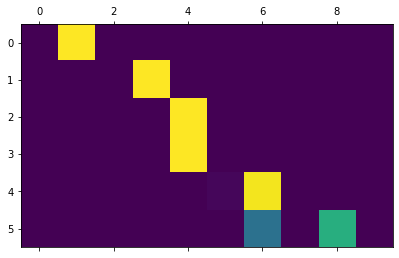

In [46]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


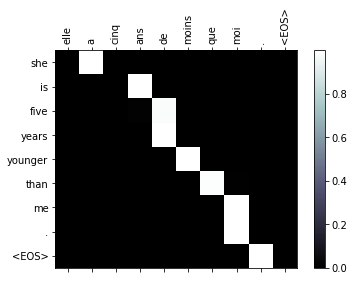

input = elle est trop petit .
output = she is too trusting . <EOS>


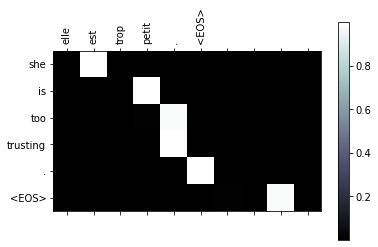

input = je ne crains pas de mourir .
output = i m not scared . <EOS>


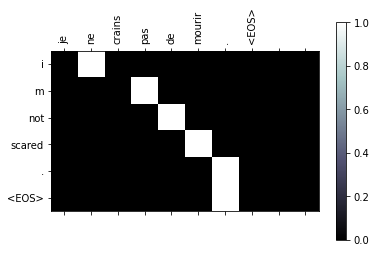

input = c est un jeune directeur plein de talent .
output = he s a talented young young . <EOS>


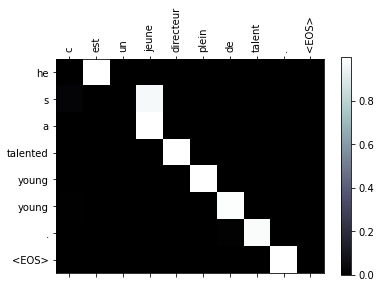

In [47]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

## Multi-Head attention

Multi-head attention as well as Transformer models introduced by [Attention Is All You Need]( https://arxiv.org/pdf/1706.03762.pdf) paper. This paper aimed to create a state-of-the-art model for machine translation tasks. After this paper Transformer and attention, models started to be used in different areas.

![the-annotated-transformer_38_0[1].png](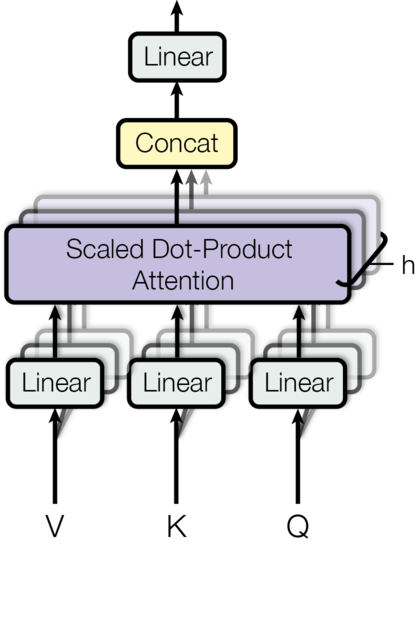)

The transformer model utilizes the self-attention mechanism. The multi-head attention mechanism is used Instead of single scaled dot product attention. Multi-head attention mechanisms projects inputs to h different dimension and h different attention layers are calculated in parallel. These different outputs are concatenated and projected again to obtain final values.

One of the main characteristics of multi-head attention is it can switch two input elements in a sequence. This change does not affect the output of the sequence except the changed elements. Due to this property, we can say that the multi-head attention mechanism looks input sequence as a set of elements. On the other hand, if the input is important for the task we can use a positional encoding.


If you want to experiment with a multi-head attention model you can use PyTorch’s [torch.nn.MultiheadAttention]( https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) function.

###Positional Encoding

Due to the multi-head attention model doesn’t keep the order of the sequence, In NLP tasks we need to add some position information to our sequence. To achieve this we can add “positional encodings” to our input embeddings. There are several positional encoding methods but in [Attention Is All You Need]( https://arxiv.org/pdf/1706.03762.pdf) paper they use sine and cosine function with different frequency’s to encode positional values. 

The advantage of this approach is the relative position of two tokens with a  constant offset gives a linear function.

###Transformer

Lastly, we are going to discuss the transformer architecture. As I mentioned before the transformer architecture contains an encoder-decoder structure because it is created for machine translation tasks.

Because of its popularity transformer models become widely available in different resources. [nn.Transformer]( https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) is available at PyTorch to create a transformer model. PyTorch also provides [nn. TransformerEncoder]( https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html) and [nn. TransformerDecoder]( https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html) as single components  to easily adopt different strategies.

One of the other libraries you can utilize is [huggingface]( https://huggingface.co/) ‘s [transformers]( https://huggingface.co/transformers/index.html) library. As you probably know huggingface is a community for NLP tasks. It contains many transformer models, datasets and resources to create your models or use one of the pre-trained models.